<a href="https://colab.research.google.com/github/ericburdett/record_detection/blob/master/record_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MaskRCNN Record Detection

This notebook contains code to segment records from historical documents. It 
uses the Matterport implementation of MaskRCNN and somewhat follows the
TowardsDataScience blog post as described [here](https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d) and pulls
from bits and pieces of the examples in the repository [here](https://github.com/matterport/Mask_RCNN/tree/master/samples).

### Grab the Matterport MaskRCNN code from GitHub

The Matterport implementation is only compatible with TensorFlow 1.x.
Use this Colab trick to make sure we are using TF1.

In [2]:
try:
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow 1.x selected.


Clone the repo and run the setup script.

In [3]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [4]:
%cd Mask_RCNN/
!python setup.py install

/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.li

Import the necessary dependencies and mount the Google Drive that contains the
dataset to be trained and tested on.

In [32]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn.model import log
from mrcnn import utils

import numpy as np
import colorsys
import argparse
import random
import cv2
import os
import time
import skimage

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

%matplotlib inline

import time
from os import listdir
import json
from xml.etree import ElementTree

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/datasets/french_record_detection_dataset.zip" "/content"
!unzip -q /content/french_record_detection_dataset.zip -d ../

### Helper Functions

Used for visualization methods in results section.

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Create the Dataset and Configuration Classes

Extend the Config class and set some various configuration variables, then
print out the configuration summary.

In [0]:
class myMaskRCNNConfig(Config):
  # Give the configuration a recognizable name
  NAME = "MaskRCNN_config"

  # Train faster with resnet50
  BACKBONE = "resnet50"

  # Set the number of GPUs to use along with the number of images per GPU
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

  # Number of classes (we would normally add +1 for the background)
    # Full + Partial + Background
  NUM_CLASSES = 2 + 1

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 131

  # Learning Rate
  LEARNING_RATE = 0.006

  # Skip detections with < 90% confidence
  DETECTION_MIN_CONFIDENCE = 0.9

  # Setting Max ground truth instances
  MAX_GT_INSTANCES = 10

  # Max Image Size
  IMAGE_MAX_DIM = 256

  # Min Image Size
  IMAGE_MIN_DIM = 128

  # Increase Batch Size
  IMAGES_PER_GPU = 4

  # Faster with fewer RoIs
  TRAIN_ROIS_PER_IMAGE = 100

  # Records will likely only have a max of 10
  MAX_GT_INSTANCES = 15

In [47]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

Extend the Dataset class to create our custom RecordDataset object. These three
methods are necessary for use with the Matterport implementation.
* load_dataset
* load_mask
* image_reference

In [0]:
class RecordDataset(Dataset):
  # Load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    # Add classes. We have two classes to add.
    self.add_class("dataset", 1, "f") # Full record
    self.add_class("dataset", 2, "p") # Partial record

    # Define data locations for images and annotations
    images_dir = os.path.join(dataset_dir, "images");
    annotations_dir = os.path.join(dataset_dir, "annotations")

    # Iterate through all files in the folder to add class, images, and annotations
    for filename in listdir(images_dir):
      # Extract image id
      image_id = filename.split('.')[0]
      
      # Setting the image file 
      img_path = os.path.join(images_dir, filename)

      # Setting the annotations file
      ann_path = os.path.join(annotations_dir, image_id + '.json')

      if os.path.exists(ann_path):
        json_file = json.load(open(ann_path))
        annotations = json_file['shapes']

        polygons = json_file['shapes']
        height = json_file['imageHeight']
        width = json_file['imageWidth']

        self.add_image('dataset',
                       image_id=image_id,
                       path=img_path,
                       width=width,
                       height=height,
                       polygons=polygons)
      else:
        image = cv2.imread(img_path)
        height = np.size(image, 0)
        width = np.size(image, 1)

        self.add_image('dataset',
                        image_id=image_id,
                        path=img_path,
                        width=width,
                        height=height,
                        polygons=[]) # empty list if there are no annotations
 
  def load_mask(self, image_id):
    # Get details of image
    info = self.image_info[image_id]
    print(info['path'])

    # Convert polygons to a bitmap mask of shape [height, width, instance_count]
    mask = np.zeros([info['height'], info["width"], len(info["polygons"])], dtype=np.uint8)
    classes = []

    for index, polygon in enumerate(info['polygons']):
      label = self.class_names.index(polygon['label'])
      points = polygon['points']

      all_points_x = [pair[0] for pair in points]
      all_points_y = [pair[1] for pair in points]

      # Get indices of pixels inside the polygon and set them to 1
      rr, cc = skimage.draw.polygon(all_points_y, all_points_x)
      mask[rr, cc, index] = 1

      # Append the label to the class list
      classes.append(label)

    # Return mask and array of class IDs of each instance
    return mask, np.asarray(classes, dtype=np.int32)
  
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    print(info)
    return info['path']

### Prepare our Train/Test Datasets and Load Images

In [49]:
train_set_path = '../french_record_detection_dataset'
test_set_path = '../french_record_detection_dataset'

# Prepare Train Set
train_set = RecordDataset()
train_set.load_dataset(train_set_path)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# Prepare Test/Val Set
test_set = RecordDataset()
test_set.load_dataset(test_set_path)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 22
Test: 22


### Examples of the Ground-Truth Masks

../french_record_detection_dataset/images/frad069_03_4e_000250_16_0002.tif


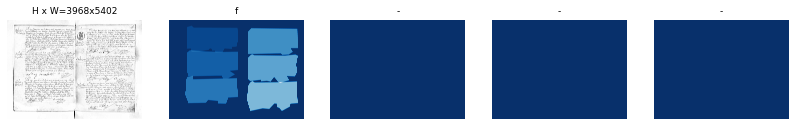

../french_record_detection_dataset/images/frad069_03_4e_000250_16_0008.tif


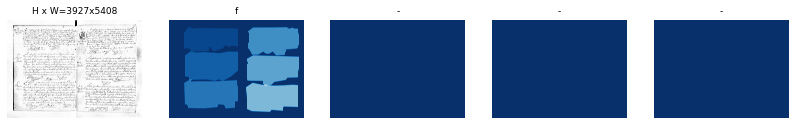

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0011.tif


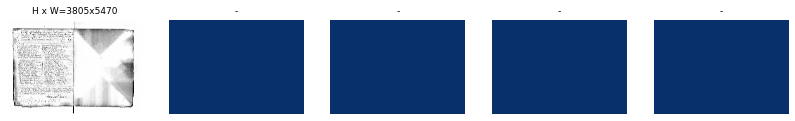

../french_record_detection_dataset/images/frad069_03_4e_000250_16_0019.tif


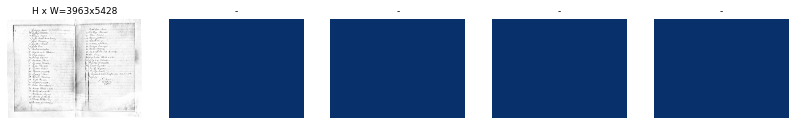

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0001.tif


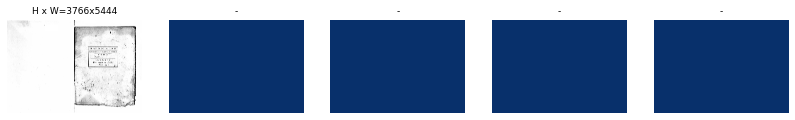

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif


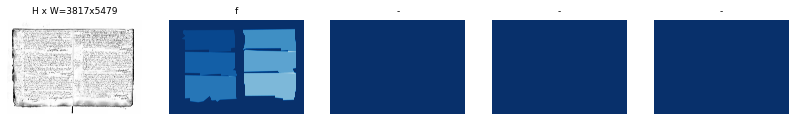

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0006.tif


KeyboardInterrupt: ignored

In [10]:
# image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in train_set.image_ids:
  image = train_set.load_image(image_id)
  mask, class_ids = train_set.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

### Loading the Model

Create the model from scratch.

In [54]:
print("Loading MaskRCNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading MaskRCNN model...


Create the model from pretrained weights.

In [0]:
# Load pretrained weights if desired
!cp "../drive/My Drive/datasets/maskrcnn.h5" "/content"
model.load_weights('../maskrcnn.h5')

### Training the Model

In [55]:
model.keras_model.metrics_tensors = []
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='all')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./maskrcnn_config20200507T0209/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0007.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0007.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0007.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0007.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0002.tif
../french_record_detection_dataset/images/frad069_03_4e_000321_10_0001.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0004.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0002.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0002.tif
../french_record_detectio

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


../french_record_detection_dataset/images/frad069_03_4e_000250_16_0006.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0006.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0019.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0001.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0007.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0019.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0001.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0019.tif
  9/131 [=>............................] - ETA: 30:26 - loss: 30.4457../french_record_detection_dataset/images/frad069_03_4e_000250_16_0019.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0001.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0001.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0007.tif
../french_record_detection_data

### Save the Model Weights

In [0]:
model_path = '../maskrcnn.h5'
model.keras_model.save_weights(model_path)
!cp '../maskrcnn.h5' "/content/drive/My Drive/datasets/"

### Load the Model in Inference Mode

In [0]:
# Loading the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='../maskrcnn.h5')

# Loading the trained weights to the custom dataset
model.load_weights('../maskrcnn.h5', by_name=True)

### Results

Show the image with the Ground-Truth masks.

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0002.tif
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5484.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  103.00000  max:  241.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  uint8


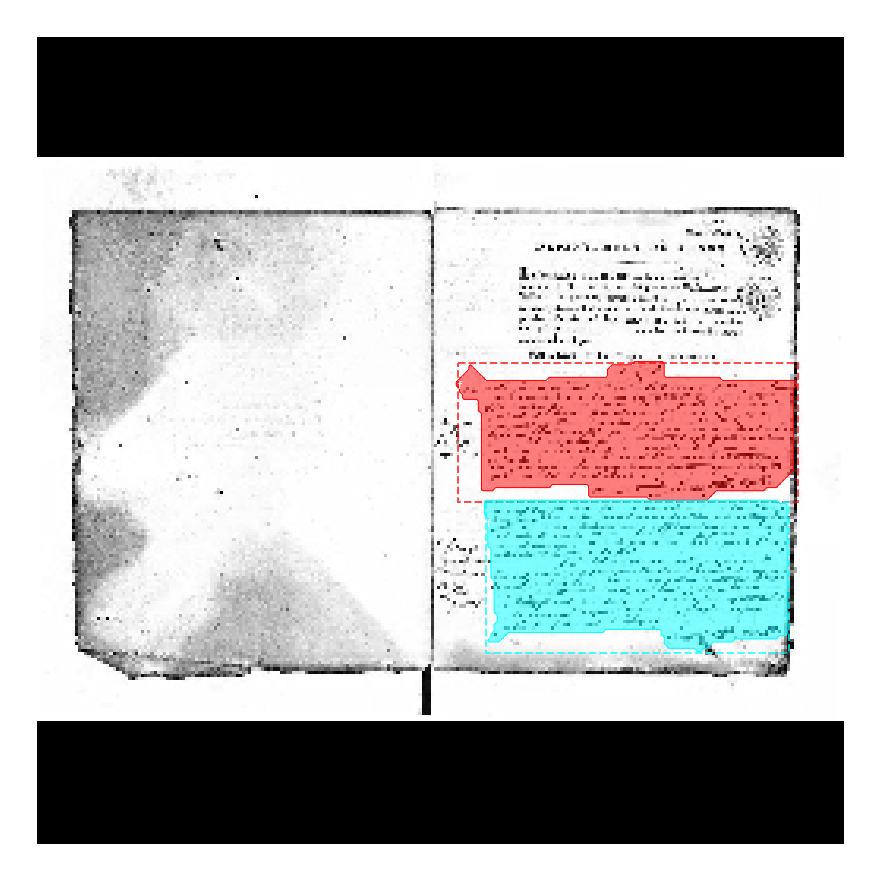

In [58]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(16, 16))

Show the image with the predicted masks.

Processing 4 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (4, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (4, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (4, 16368, 4)         min:   -1.41976  max:    2.16878  float32


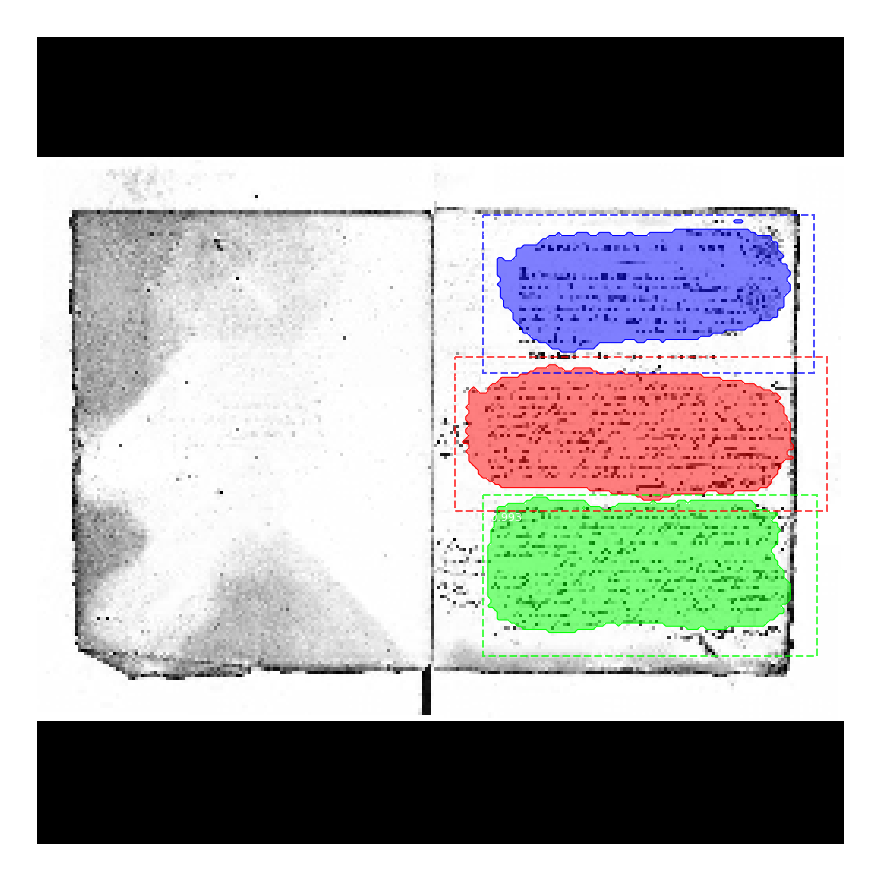

In [60]:
results = model.detect([original_image, original_image, original_image, original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=get_ax(size=16))

### Unused Code

This code will resize an image AND resize the associated mask.

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0002.tif
{'id': 'frad069_03_4e_000103_15_0002', 'source': 'dataset', 'path': '../french_record_detection_dataset/images/frad069_03_4e_000103_15_0002.tif', 'width': 5484, 'height': 3825, 'polygons': [{'label': 'f', 'points': [[3029.181818181818, 2260.6363636363635], [3742.818181818182, 2219.7272727272725], [3756.454545454545, 2306.090909090909], [4556.454545454545, 2333.3636363636365], [4624.636363636364, 2274.2727272727275], [5029.181818181818, 2251.5454545454545], [5147.363636363636, 2119.7272727272725], [5161.0, 1519.7272727272727], [4265.545454545455, 1492.4545454545455], [4256.454545454545, 1378.8181818181818], [3892.818181818182, 1410.6363636363637], [3888.272727272727, 1492.4545454545455], [3061.0, 1515.1818181818182], [2951.909090909091, 1410.6363636363637], [2851.909090909091, 1533.3636363636363], [2901.909090909091, 1637.909090909091], [3006.4545454545455, 1642.4545454545455]], 'group_id': None, 'shape_type': 'p

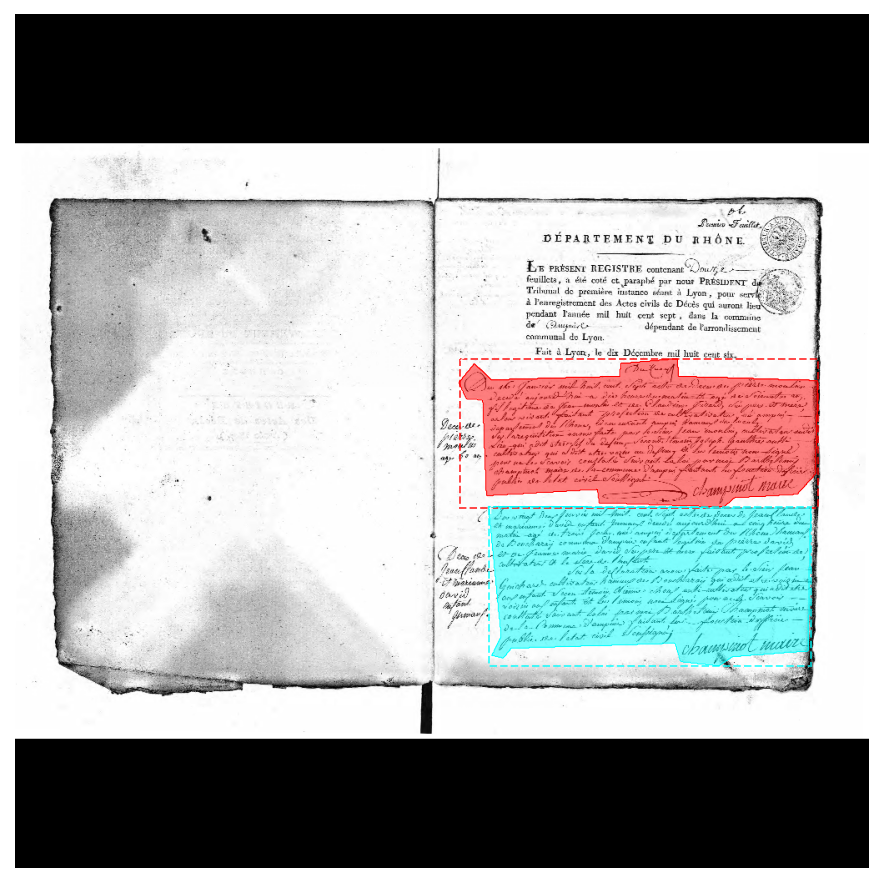

In [34]:
# Load random image and mask.
image_id = np.random.choice(train_set.image_ids, 1)[0]
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, train_set.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)